``` David Pineda Peña

Máster Universitario en Lógica, Computación e Inteligencia Artificial
Universidad de Sevilla 
```

# Cuestionario 1. Seminario Avanzado de Aprendizaje Automático

# Ejercicio 1

**Ejercicio 1: Caminos de decisión**

Crear un modelo de explicabilidad que tome un árbol *scikit-learn* y una instancia como entrada. La salida debe ser un texto en castellano que consideremos una explicación, esto es, el texto debe ser del tipo: *"En primer lugar miramos la temperatura con un umbral 37.2, puesto que la instancia tiene temperatura 35 y es menor que el umbral, tomamos la rama de la izquierda..."*.

Aplicarlo sobre el conjunto de datos de la Práctica 1.

- Tomando un árbol de regresión 
- Tomando un árbol de clasificación

### Load Practice 1 dataset

In [33]:
import warnings
warnings.filterwarnings('ignore')

# General imports
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

# Exercise 1
import requests
import zipfile
import io
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Exercise 2
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from alibi.explainers import ALE, plot_ale

# Exercise 3
import PIL.Image
from matplotlib import pylab as P
import torch
from torchvision import models, transforms
import saliency.core as saliency

%matplotlib inline


### Load dataset from Practice 1

Leemos el archivo, tal y como se realizó en la Práctica 1

In [34]:
# URL del archivo zip en GitHub
url = 'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip'

response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
with zip_file.open('aa-domestic-delays-2018.csv') as file:
        import pandas as pd
        aad18_df = pd.read_csv(file)

In [35]:
aad18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

### Process dataset

Aplicamos las mismas transformaciones y procesamiento de datos que las vistas en la práctica 1

In [36]:
# Cambiamos el tipo de dato de 'object' a 'datetime'
aad18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])
# Creamos el atributo 'DEP_MONTH' con el mes planeado para el despegue
aad18_df['DEP_MONTH'] = aad18_df['PLANNED_DEP_DATETIME'].dt.month
# Creamos el atributo 'day_of_the_week' (DOW) con el día de la semana planeado para el despegue
aad18_df['DEP_DOW'] = aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek
# Eliminamos el atributo 'PLANNED_DEP_DATETIME'
aad18_df = aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [37]:
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']

In [38]:
# Booleano determinando si ORIGIN o DEST están en la lista 'hubs'
is_origin_hub = aad18_df['ORIGIN'].isin(hubs)
is_dest_hub = aad18_df['DEST'].isin(hubs)
# Creamos los nuevos atributos ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB'] = 0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
aad18_df['DEST_HUB'] = 0
aad18_df.loc[is_dest_hub, 'DEST_HUB'] = 1
# Eliminamos atributos
aad18_df = aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

In [39]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(aad18_df)
aad18_df = pd.DataFrame(aad18_df, columns=aad18_df.columns)

#### Train models (DecissionTreeRegressor, DecissionTreeClassifier)

In [40]:
rand = 9

# preprocessnig for regression and classification
X = aad18_df
y = aad18_df['ARR_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

# regression
dt_reg = DecisionTreeRegressor(random_state=rand)
dt_reg.fit(X_train, y_train)

# classification
y = aad18_df['ARR_DELAY']
y = np.where(y > 0, 1, 0) # 1 if delay, 0 if not
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)
dt_clf = DecisionTreeClassifier(random_state=rand)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=9)

In [41]:
def explain_decision_tree(tree, feature_names, instance):
    """
    Generate a human-readable explanation of the decision path taken by an instance in the decision tree.

    Parameters:
    - tree: Trained decision tree (regressor or classifier)
    - feature_names: List of feature names
    - instance: Instance to explain

    Returns:
    - explanation: Human-readable explanation
    """
    node = 0
    explanation = "La ruta de decisión para la instancia dada es la siguiente:\n"
    
    while True:
        if tree.tree_.feature[node] == -2:
            if tree.__class__.__name__ == "DecisionTreeClassifier":
                class_name = tree.classes_[tree.tree_.value[node].argmax()]
                explanation += f"Se alcanzó el nodo hoja. \nClase predicha: {class_name}."
            else:
                value = tree.tree_.value[node].squeeze()
                explanation += f"Se alcanzó el nodo hoja. \nValor predicho: {value:.2f}."
            break
        
        feature = feature_names[tree.tree_.feature[node]]
        threshold = tree.tree_.threshold[node]
        instance_value = instance[feature]
        
        explanation += f"Nodo {node}: Mirar {feature} con un umbral {threshold:.2f}.\n"
        if instance_value <= threshold:
            explanation += f"Como {instance_value} <= {threshold:.2f}, se toma la rama izquierda.\n"
            node = tree.tree_.children_left[node]
        else:
            explanation += f"Como {instance_value} > {threshold:.2f}, se toma la rama derecha.\n"
            node = tree.tree_.children_right[node]
    
    return explanation


In [42]:
# choose an instance to explain
instance = X_test.iloc[0]

# explain the decision tree for both (regression and classification) for the chosen instance
print("Explicación para el árbol de regresión:")
print(explain_decision_tree(dt_reg, X.columns, instance))
print("\n")

print("Explicación para el árbol de clasificación:")
print(explain_decision_tree(dt_clf, X.columns, instance))
print("\n")


Explicación para el árbol de regresión:
La ruta de decisión para la instancia dada es la siguiente:
Nodo 0: Mirar ARR_DELAY con un umbral 73.50.
Como 5.0 <= 73.50, se toma la rama izquierda.
Nodo 1: Mirar ARR_DELAY con un umbral 8.50.
Como 5.0 <= 8.50, se toma la rama izquierda.
Nodo 2: Mirar ARR_DELAY con un umbral -11.50.
Como 5.0 > -11.50, se toma la rama derecha.
Nodo 132: Mirar ARR_DELAY con un umbral -2.50.
Como 5.0 > -2.50, se toma la rama derecha.
Nodo 150: Mirar ARR_DELAY con un umbral 2.50.
Como 5.0 > 2.50, se toma la rama derecha.
Nodo 160: Mirar ARR_DELAY con un umbral 5.50.
Como 5.0 <= 5.50, se toma la rama izquierda.
Nodo 161: Mirar ARR_DELAY con un umbral 3.50.
Como 5.0 > 3.50, se toma la rama derecha.
Nodo 163: Mirar ARR_DELAY con un umbral 4.50.
Como 5.0 > 4.50, se toma la rama derecha.
Se alcanzó el nodo hoja. 
Valor predicho: 5.00.


Explicación para el árbol de clasificación:
La ruta de decisión para la instancia dada es la siguiente:
Nodo 0: Mirar ARR_DELAY con un 

# Ejercicio 2

**Ejercicio 2: Accumulated Local Effects (ALE)**

Los *ALE Plots* son una técnica XAI para datos tabulados que mejoran los *Partial Dependence Plots*. Se espera que el alumno:

- Busque documentación y explique en qué consiste esta técnica y cuándo sería útil utilizarla
- La aplique sobre el conjunto de datos de la Práctica 2
- Compare esta técnica con otras técnicas sobre datos tabulados, indicando *explícitamente* sus ventajas e inconvenientes.

---

ALE describe cómo las características influencian la predicción de un modelo en promedio. Son una alternativa no sesgada y más rápida que los PDPs.

### Motivación
Si las características de un modelo están correladas, los PDPs no son fiables. Esto puede ampliamente sesgar el efecto predicho.

Por comparar y resumir cómo cada tipo de *plot* calcula el efecto de una característica en un determinado valor:

- PDPs: "Déjame mostrarte lo que el modelo predice en promedio cuando cada instancia de datos tiene el valor v para esa característica. Ignoro si el valor v tiene sentido para todas las instancias de datos."

- ALE: "Déjame mostrarte cómo cambian las predicciones del modelo en una pequeña 'ventana' de la característica alrededor de v para las instancias de datos en esa ventana."


La forma en la que los ALE Plots ayudan a comprender el efecto que tiene una variable de entrada sobre la predicción del modelo, es promediando los efectos locales en diferentes subconjuntos de datos, y acumulando estos efectos a lo largo del rango de la variable. Esto permite observar las variaciones sobre la predicción, ante cambios en dicha variable, mientras se mantienen fijas todas las demás.

`Funcionamiento de los Ale Plots`
1. Selección de Datos: Se selecciona un rango de valores para la variable de interés.
2. División en Intervalos: Este rango se divide en varios intervalos pequeños.
3. Cálculo de Efectos Locales: Para cada intervalo, el modelo se evalúa en dos puntos cercanos dentro del intervalo mientras se mantienen constantes las otras variables. 
<br>La diferencia en las predicciones del modelo entre estos dos puntos se calcula para estimar el efecto local de la variable de interés
4. Acumulación de Efectos: Los efectos locales se acumulan a lo largo del rango de la variable para construir el gráfico, mostrando cómo el cambio en la variable afecta la predicción.


#### Load California Housing Dataset

In [43]:
housing = fetch_california_housing(as_frame=True)
housing_data = housing.data
housing_target = housing.target
housing_feature_names = housing.feature_names

In [44]:
housing_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


#### Split Data and Train models (LinearRegression, RandomForestRegressor)

In [45]:
# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(housing_data, housing_target, test_size=0.2, random_state=0)

In [46]:
# as array X_train
X_train.values

array([[   4.2386    ,    6.        ,    7.72307692, ...,    3.50769231,
          33.83      , -117.55      ],
       [   4.3898    ,   52.        ,    5.32662192, ...,    3.32214765,
          37.73      , -122.44      ],
       [   3.9333    ,   26.        ,    4.66847826, ...,    2.77717391,
          33.83      , -118.        ],
       ...,
       [   3.1977    ,   31.        ,    3.64122137, ...,    1.7913486 ,
          36.58      , -121.9       ],
       [   5.6315    ,   34.        ,    4.54059829, ...,    2.24786325,
          33.62      , -117.93      ],
       [   1.3882    ,   15.        ,    3.9295302 , ...,    3.43624161,
          32.8       , -115.56      ]])

In [47]:
# linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [48]:
mean_squared_error(y_test, lr.predict(X_test))

0.528984167036721

In [49]:
# random forest model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
mean_squared_error(y_test, rf.predict(X_test))

0.26318249096640645

#### Apply ALE method

In [51]:
lr_ale = ALE(lr.predict, feature_names=housing_feature_names, target_names=['Value in 100,000$\'s'])
rf_ale = ALE(rf.predict, feature_names=housing_feature_names, target_names=['Value in 100,000$\'s'])

In [52]:
lr_exp = lr_ale.explain(X_train.values)
rf_exp = rf_ale.explain(X_train.values)

array([[<Axes: xlabel='MedInc', ylabel='ALE'>,
        <Axes: xlabel='HouseAge', ylabel='ALE'>,
        <Axes: xlabel='AveRooms', ylabel='ALE'>,
        <Axes: xlabel='AveBedrms', ylabel='ALE'>],
       [<Axes: xlabel='Population', ylabel='ALE'>,
        <Axes: xlabel='AveOccup', ylabel='ALE'>,
        <Axes: xlabel='Latitude', ylabel='ALE'>,
        <Axes: xlabel='Longitude', ylabel='ALE'>]], dtype=object)

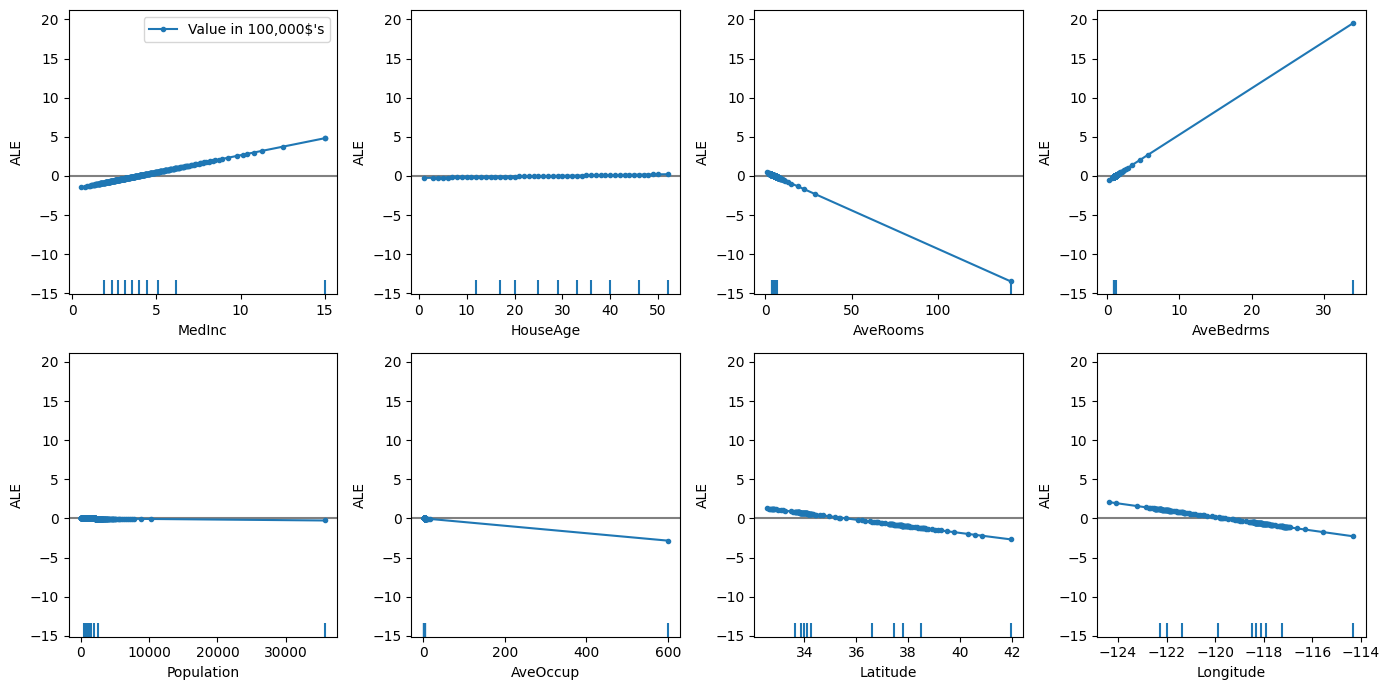

In [53]:
plot_ale(lr_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

Como era de esperar, los gráficos de efectos de características son lineales porque usamos un modelo lineal.

array([[<Axes: xlabel='MedInc', ylabel='ALE'>]], dtype=object)

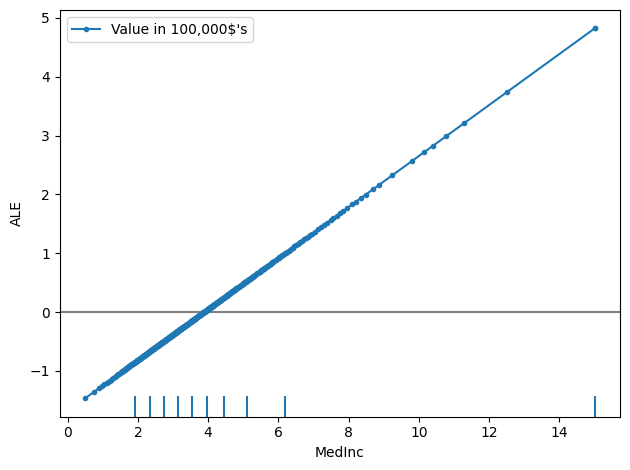

In [54]:
plot_ale(lr_exp, features=['MedInc'])

Ahora vamos a comprobar los plots sobre el clasificador de Random Forest

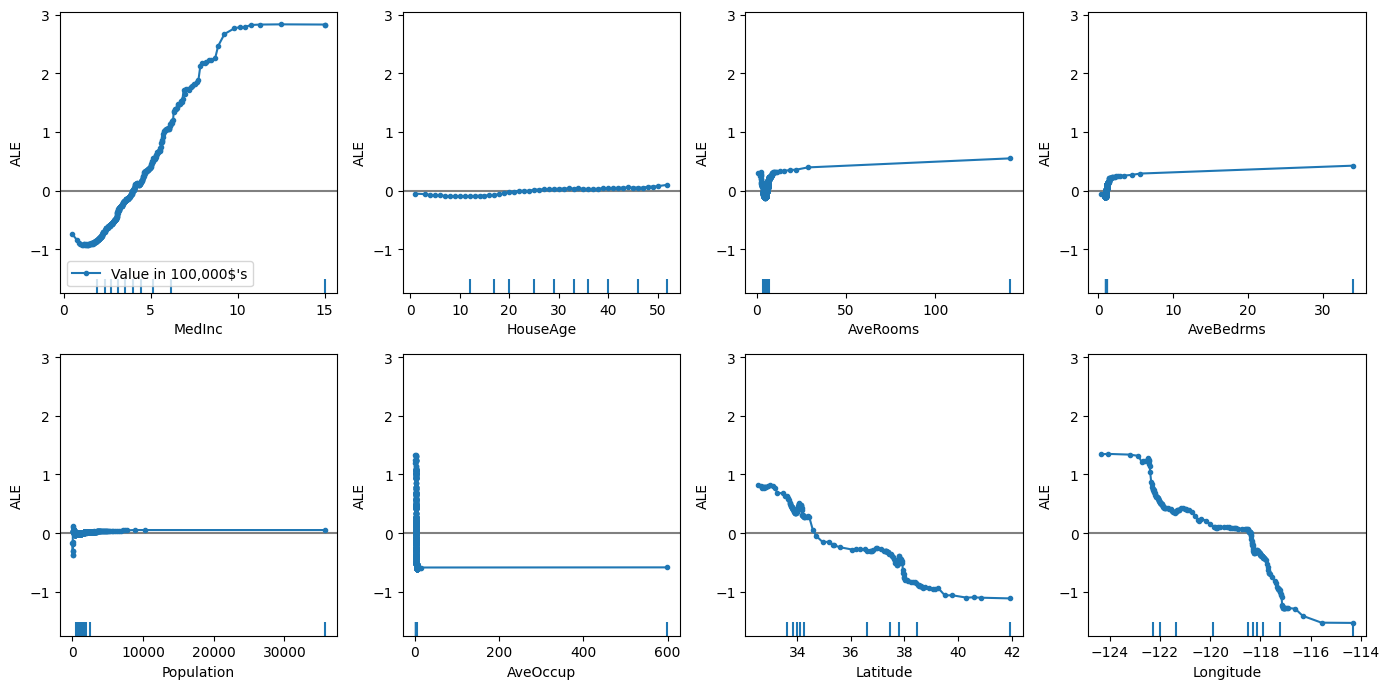

In [55]:
axes = plot_ale(rf_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

Podemos observar como las gráficas no son lineales y son menos monótonas (más complejas)

In [56]:
housing_feature_names[rf[1].feature_importances_.argmax()]

'MedInc'

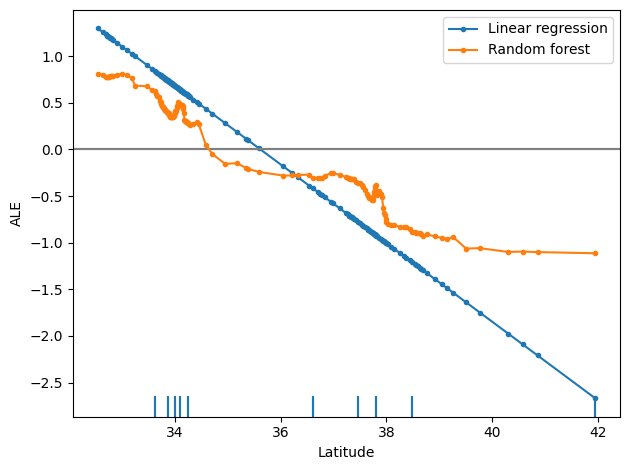

In [57]:
fig, ax = plt.subplots()
plot_ale(lr_exp, features=['Latitude'], ax=ax, line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, features=['Latitude'], ax=ax, line_kw={'label': 'Random forest'});

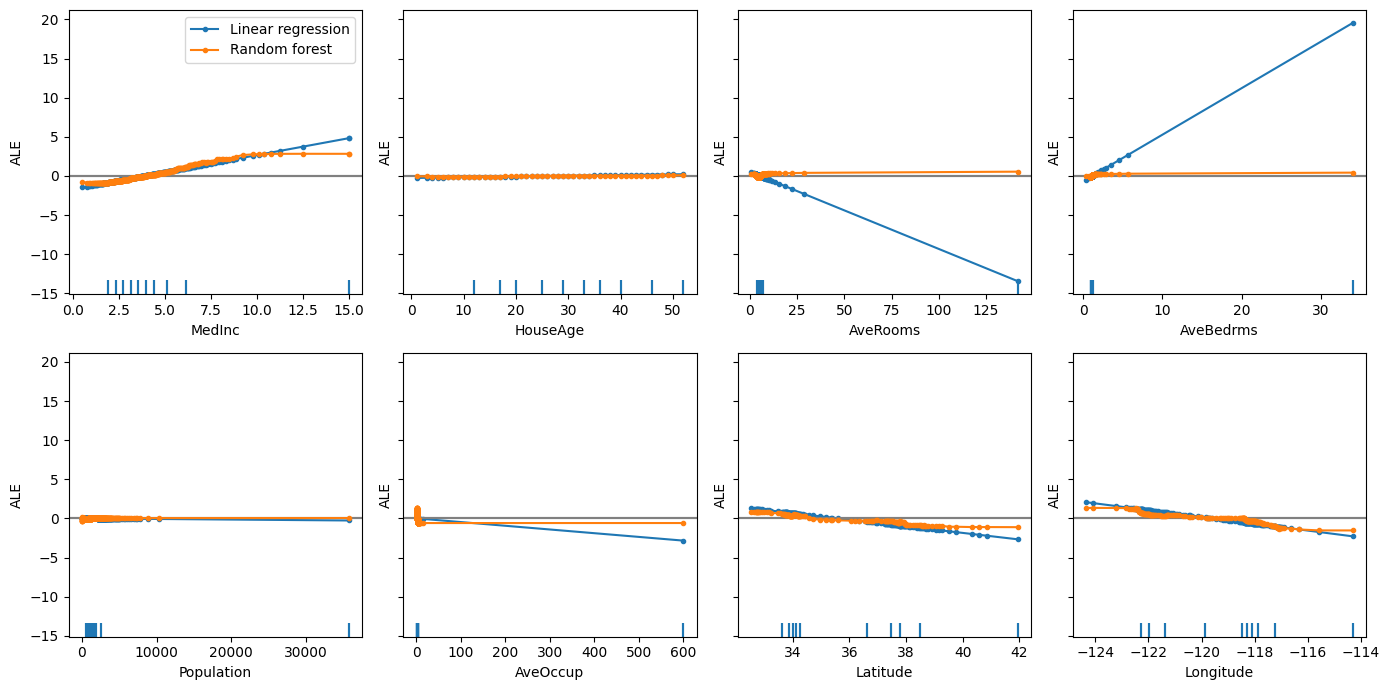

In [58]:
fig, ax = plt.subplots(2, 4, sharey='all');

plot_ale(lr_exp, ax=ax, fig_kw={'figwidth':14, 'figheight': 7},
         line_kw={'label': 'Linear regression'});
plot_ale(rf_exp, ax=ax, line_kw={'label': 'Random forest'});

#### Comparison table between ALE and other explainability methods

| Comparación con PDPs (Gráficos de Dependencia Parcial) | |
|---------------------------------------------------------|--------------------------------------------|
| **PDPs**                                                | **ALE Plots**                           |
| **Ventajas**                                            | **Ventajas**                               |
| Fácil de interpretar, muestra el efecto promedio de las características. | Considera las correlaciones entre características, proporciona efectos de características no sesgados, captura efectos locales. |
| **Desventajas**                                         | **Desventajas**                            |
| Asume independencia de las características, lo que puede llevar a interpretaciones sesgadas si las características están correlacionadas. | Más complejo de interpretar, mayor coste computacional. |
---
| Comparación con Valores SHAP | |
|------------------------------|-------------------------------------------|
| **SHAP Values**             | **ALE Plots**                          |
| **Ventajas**                 | **Ventajas**                              |
| Proporciona una medida unificada de la importancia de las características, considera efectos de interacción, produce atribuciones de características consistentes y aditivas. | Menos costoso computacionalmente que los valores SHAP para conjuntos de datos grandes, se centra en efectos locales. |
| **Desventajas**              | **Desventajas**                           |
| Intensivo computacionalmente, especialmente para conjuntos de datos grandes y modelos complejos. | Proporciona menos detalle granular sobre las interacciones de características en comparación con los valores SHAP. |
---
| Comparación con LIME (Explicaciones Model-Agnósticas Locales e Interpretables) | |
|-------------------------------------------------------------------------------|---------------------------------------------|
| **LIME**                                                                      | **ALE Plots**                            |
| **Ventajas**                                                                  | **Ventajas**                                |
| Proporciona interpretaciones locales, independiente del modelo, útil para depurar predicciones individuales. | Más estable y consistente que LIME, se enfoca en el efecto de las características en todo el conjunto de datos. |
| **Desventajas**                                                               | **Desventajas**                             |
| Los resultados pueden variar debido a su dependencia del muestreo y modelos sustitutos locales, puede ser inestable. | No es tan local como LIME, lo que puede ser menos útil para explicaciones de instancias individuales. |


# Ejercicio 3

**Ejercicio 3: Blur Integrated Gradients**

Uno de los principales inconvenientes que tiene el uso de la técnica *Integrated Gradients* es la influencia que tiene el *baseline* en el resultado. Para intentar solventar este problema [...] presentaron en 2020 una variante de esta técnica llamada **Blur-IG**. 

Explica en qué consiste esta técnica, cuáles son sus ventajas respecto al método Integrated Gradients y aplícala a la imagen de la cacatúa de la Práctica 3.

---

**Blur Integrated Gradients** es una técnica avanzada para atribuir las predicciones de redes neuronales profundas en tareas de visión. Mejora el método tradicional de Integrated Gradients (IG) al incorporar dimensiones de escala y frecuencia, logrando explicaciones más claras y detalladas.

#### Principio fundamental

Blur IG utiliza la técnica de desenfoque gaussiano para crear una serie de imágenes difuminadas desde la imagen original hasta versiones con distintos niveles de desenfoque. Luego, calcula los gradientes de la salida de la red respecto a cada imagen difuminada y los integra para generar un mapa de atribución que muestra la importancia de cada píxel en diferentes escalas.

#### Ventajas sobre Integrated Gradients

1. **Dimensión de Escala/Frecuencia**: Blur IG proporciona puntuaciones en la dimensión de escala/frecuencia, mostrando cómo el reconocimiento del objeto por parte de la red varía con diferentes niveles de detalle.
  
2. **Perturbaciones sin Artefactos**: El uso de desenfoque gaussiano evita los artefactos que pueden surgir con la interpolación en IG tradicional, lo que lleva a atribuciones más precisas y fiables.

3. **Eliminación del Parámetro Base**: Blur IG no requiere seleccionar una base específica (como una imagen negra), utilizando en su lugar versiones difuminadas de la propia entrada, lo que simplifica el proceso y mejora la coherencia de las explicaciones.

In [59]:
# Utility methods taken from (https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((299, 299))
    im = np.asarray(im)
    return im

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)
    
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

#### Loading the InceptionV3 model for ImageNet

In [60]:
model = models.inception_v3(pretrained=True, init_weights=False)
eval_mode = model.eval()

In [61]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str] # get the target class index
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

#### Load an image and infer

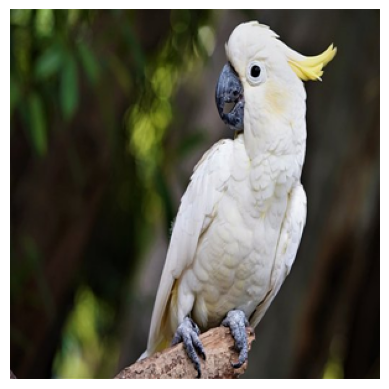

In [62]:
# load the image
im_orig = LoadImage('data/cockatoo.jpeg')
im_tensor = PreprocessImages([im_orig])
# show the image
ShowImage(im_orig)

predictions = model(im_tensor)
predictions = predictions.detach().numpy()
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

im = im_orig.astype(np.float32)

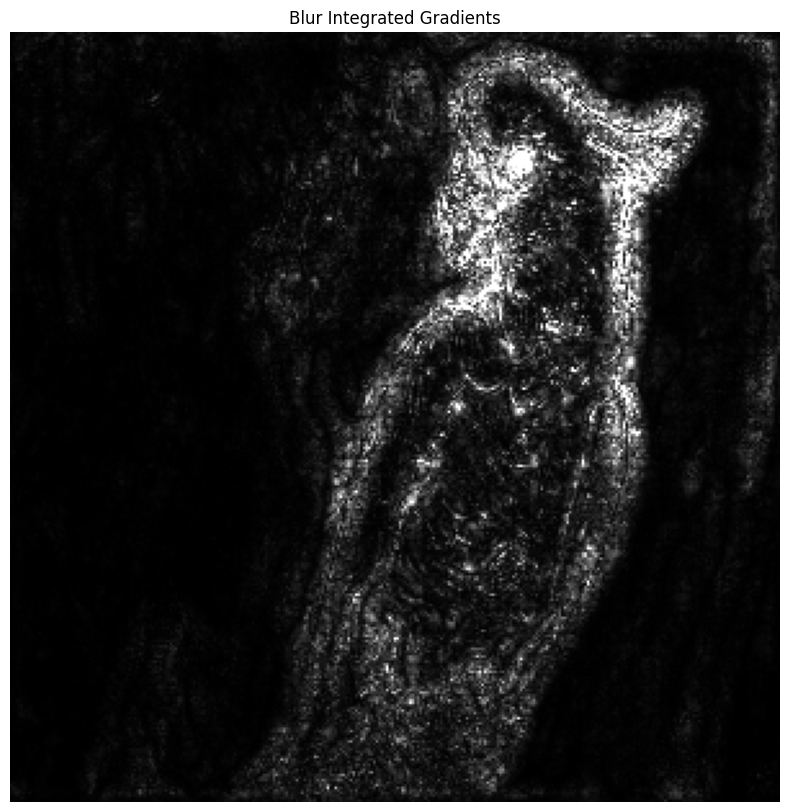

In [63]:
# construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()
blur_ig = saliency.BlurIG()

# compute the Blur IG mask.
blur_ig_mask_3d = blur_ig.GetMask(
  im, call_model_function, call_model_args, batch_size=20)

# call the visualization methods to convert the 3D tensors to 2D grayscale.
blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

# set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# render the saliency masks.
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))

---

### Bibliografía

- aliby library repository - (Exercise 2): [https://github.com/SeldonIO/alibi]
- aliby ALE method docs - (Exercise 2): [https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html]
- saliency documentation and methods - (Exercise 3): [https://github.com/PAIR-code/saliency/blob/master/Examples_pytorch.ipynb]